In [1]:
%reset -f

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.polygons import get_obj_polygon
from utils.visualize import visualize_polygon
from PIL import Image

In [3]:
image_path = './data_stage_2/351.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
tooth_detection_model = YOLO("./models/Tooth/best.pt")
tooth_results = tooth_detection_model.predict(image_path, conf=0.80)
                                         

cej_bone_detection_model = YOLO("./models/CEJ_Bone/best.pt")
cej_bone_results = cej_bone_detection_model.predict(image_path, conf=0.80, max_det=2, iou=0.9)


image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/data_stage_2/351.jpg: 512x640 3 tooths, 122.9ms
Speed: 5.1ms preprocess, 122.9ms inference, 813.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/data_stage_2/351.jpg: 512x640 1 bone_level, 1 CEJ, 61.1ms
Speed: 2.9ms preprocess, 61.1ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)


In [ ]:
p1 = get_obj_polygon(tooth_results, image)
p2 = get_obj_polygon(cej_bone_results, image)

In [7]:
for p in p1['tooth']:
    print(p.centroid.x)

137.66447415311617
330.21574619234053
547.4738031373382


In [8]:
from shapely.geometry import Polygon

def filter_small_polygons(polygons, min_area=500):
    """
    Filters out polygons with area smaller than the specified threshold.

    Parameters:
        polygons (list of shapely.geometry.Polygon): List of polygons to filter.
        min_area (float): The minimum area threshold for keeping polygons.

    Returns:
        List of shapely.geometry.Polygon: Filtered polygons that have an area larger than `min_area`.
    """
    filtered_polygons = []

    for polygon in polygons:
        # Check if the area of the polygon is greater than or equal to min_area
        if polygon.area >= min_area:
            filtered_polygons.append(polygon)
    
    return filtered_polygons

min_area = 150

# Filter polygons
tooth_polygons = filter_small_polygons(p1['tooth'], min_area)
cej_polygon = filter_small_polygons(p2['CEJ'], min_area)
bone_polygon = filter_small_polygons(p2['bone_level'], min_area)

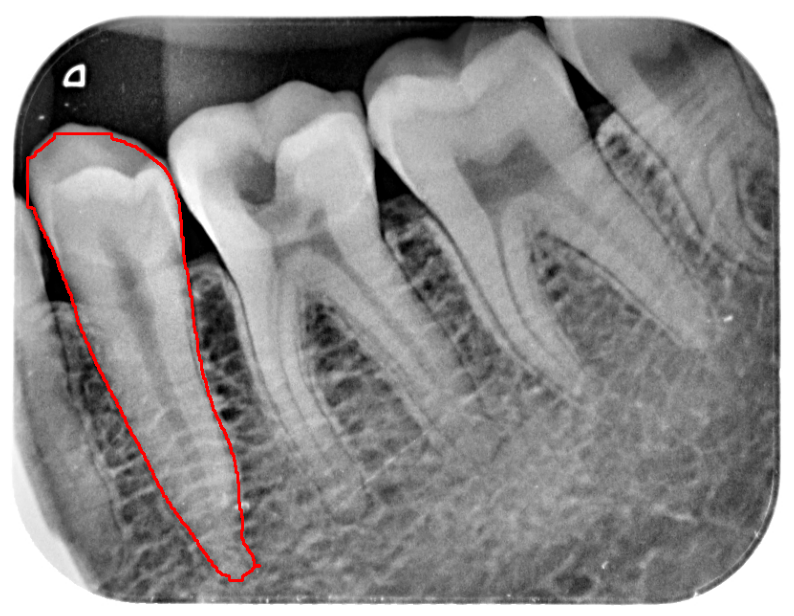

In [11]:
visualize_polygon(tooth_polygons[0:1], image)

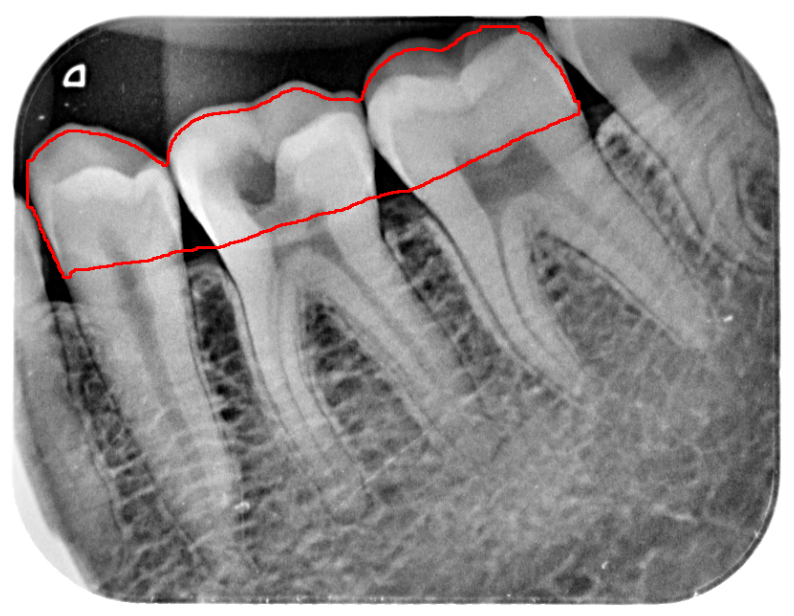

In [12]:
visualize_polygon(cej_polygon, image)

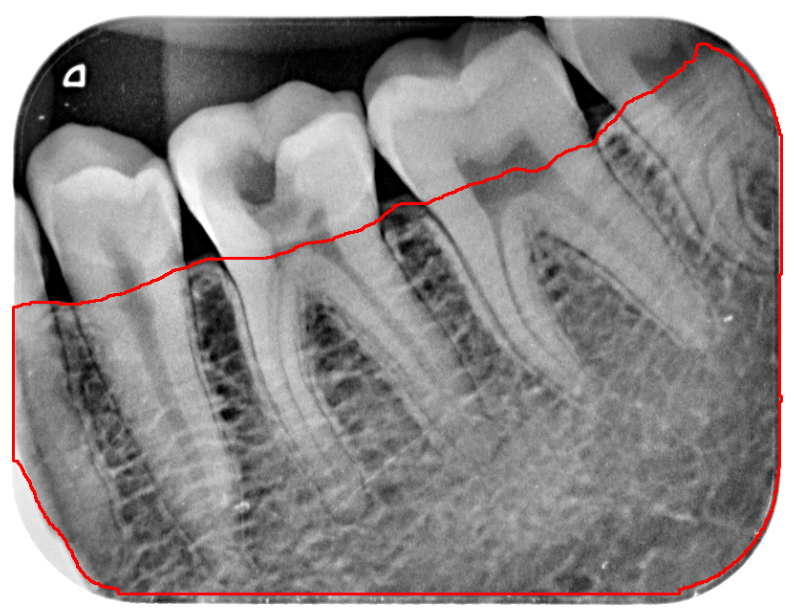

In [13]:
visualize_polygon(bone_polygon, image)

In [14]:
import numpy as np
from shapely.geometry import Polygon, LineString
from sklearn.decomposition import PCA

def get_major_axes(polygons):
    """
    Given a list of polygons, return a list of their major axes as LineStrings.
    
    Parameters:
        polygons (list of shapely.geometry.Polygon): List of polygons.

    Returns:
        List of shapely.geometry.LineString: Major axes of the polygons.
    """
    major_axes = []

    for polygon in polygons:
        # Get exterior coordinates
        x, y = polygon.exterior.xy
        points = np.column_stack((x[:-1], y[:-1]))  # Exclude last point (duplicate of first)

        # Compute centroid
        centroid = np.array([polygon.centroid.x, polygon.centroid.y])

        # Apply PCA to get principal components
        pca = PCA(n_components=2)
        pca.fit(points - centroid)  # Center the points

        # Get major axis direction
        major_axis_dir = pca.components_[0]
        major_length = pca.explained_variance_[0] ** 0.5  # Scale by variance

        # Compute major axis line (extend it for visualization)
        major_axis_start = centroid - major_axis_dir * major_length * 100
        major_axis_end = centroid + major_axis_dir * major_length * 100

        # Convert to LineString
        major_axis_line = LineString([major_axis_start, major_axis_end])
        major_axes.append(major_axis_line)

    return major_axes

In [15]:
major_axes = get_major_axes(tooth_polygons)

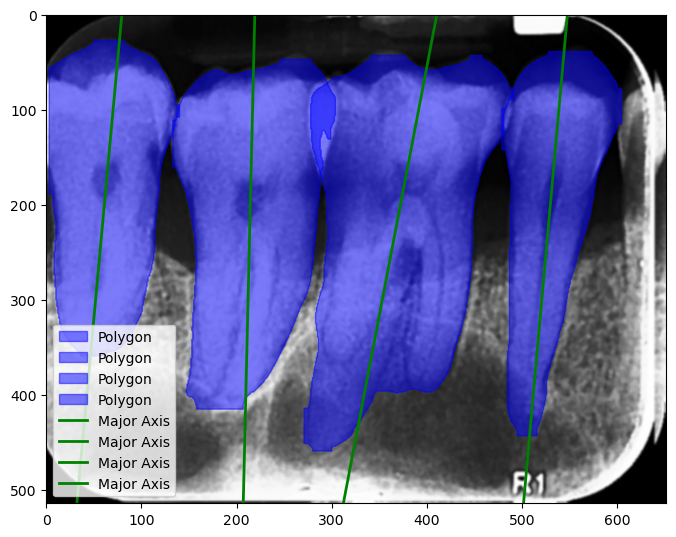

In [116]:
# Plot the image
# Ensure 'image' is a PIL image
if isinstance(image, np.ndarray):
    img = Image.fromarray(image)  # Convert NumPy array to PIL image
else:
    img = image  # Use as-is if already a PIL image
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)

# Plot the polygons
for polygon in tooth_polygons:
    x, y = polygon.exterior.xy
    ax.fill(x, y, alpha=0.5, color='blue', label="Polygon")

# Plot major axes
for axis in major_axes:
    x, y = axis.xy
    ax.plot(x, y, 'g-', linewidth=2, label="Major Axis")

# Set axis limits based on polygon bounds
# x_min = min([poly.bounds[0] for poly in p1['tooth']]) - 20
# x_max = max([poly.bounds[2] for poly in p1['tooth']]) + 20
# y_min = min([poly.bounds[1] for poly in p1['tooth']]) - 20
# y_max = max([poly.bounds[3] for poly in p1['tooth']]) + 20

# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_max, y_min)  # Invert y-axis for correct image coordinates
# Set full image display limits
ax.set_xlim(0, img.width)
ax.set_ylim(img.height, 0) 
ax.legend()
plt.show()

In [16]:
def plot_results(image, polygons, major_axes, lower_intersections):
    """
    Plots the polygons, major axes, and lower intersection points on an image.

    Parameters:
        image (PIL.Image or np.ndarray): The background image.
        polygons (list of shapely.geometry.Polygon): List of polygons.
        major_axes (list of shapely.geometry.LineString): List of major axes.
        lower_intersections (list of shapely.geometry.Point or None): Lower intersection points.
    """
    # Ensure image is a PIL image
    if isinstance(image, np.ndarray):
        img = Image.fromarray(image)  # Convert NumPy array to PIL image
    else:
        img = image  # Use as-is if already a PIL image

    # Plot the image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    # Plot the polygons
    for polygon in polygons:
        x, y = polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, color='blue')  

    # Plot major axes
    for axis in major_axes:
        x, y = axis.xy
        ax.plot(x, y, 'g-', linewidth=2)  

    # Plot lower intersection points as red dots
    for point in lower_intersections:
        if point:
            ax.plot(point.x, point.y, 'ro', markersize=8)  # Red dot for lower intersection

    # Set full image display limits
    ax.set_xlim(0, img.width)
    ax.set_ylim(img.height, 0)  # Invert y-axis to align with image coordinates

    plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPoint, Point
from PIL import Image

def find_lower_intersection(major_axes, polygons):
    """
    Finds the lower (smallest y-coordinate) intersection point of each line with its corresponding polygon.

    Parameters:
        major_axes (list of shapely.geometry.LineString): List of major axes (lines).
        polygons (list of shapely.geometry.Polygon): List of polygons.

    Returns:
        List of the lowest intersection points (shapely.geometry.Point or None if no intersection).
    """
    lower_intersections = []

    for axis, polygon in zip(major_axes, polygons):
        # Get the polygon's border as a LineString
        polygon_border = LineString(polygon.exterior.coords)

        # Compute intersection of the line with the polygon border
        intersection = axis.intersection(polygon_border)

        # Check if we have multiple intersection points
        if isinstance(intersection, MultiPoint):
            # Get the lowest intersection (smallest y-coordinate)
            lowest_point = max(intersection.geoms, key=lambda p: p.y)
            lower_intersections.append(lowest_point)

        elif isinstance(intersection, Point):
            lower_intersections.append(intersection)  # Single intersection

        else:
            lower_intersections.append(None)  # No intersection found

    return lower_intersections


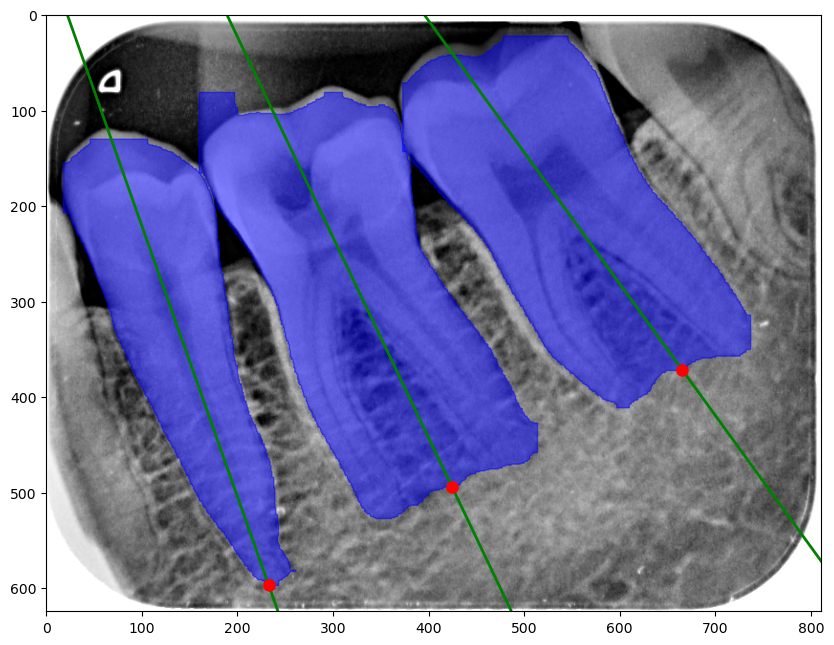

In [18]:
roots = find_lower_intersection(major_axes=major_axes, polygons= tooth_polygons)
plot_results(image, tooth_polygons, major_axes, roots)

In [19]:
def find_lower_intersections_for_shape(polygon, axes):
    """
    Finds the lower (higher y-coordinate) intersection points of multiple axes with a single polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The shape (polygon).
        axes (list of shapely.geometry.LineString): List of major axes (lines).

    Returns:
        List of the lowest intersection points (shapely.geometry.Point or None if no intersection).
    """
    lower_intersections = []

    # Get the polygon's border as a LineString
    polygon_border = LineString(polygon.exterior.coords)

    for axis in axes:
        # Compute intersection of the line with the polygon border
        intersection = axis.intersection(polygon_border)

        # Check if we have multiple intersection points
        if isinstance(intersection, MultiPoint):
            # Get the lower intersection (largest y-coordinate)
            lowest_point = max(intersection.geoms, key=lambda p: p.y)
            lower_intersections.append(lowest_point)

        elif isinstance(intersection, Point):
            lower_intersections.append(intersection)  # Single intersection

        else:
            lower_intersections.append(None)  # No intersection found

    return lower_intersections


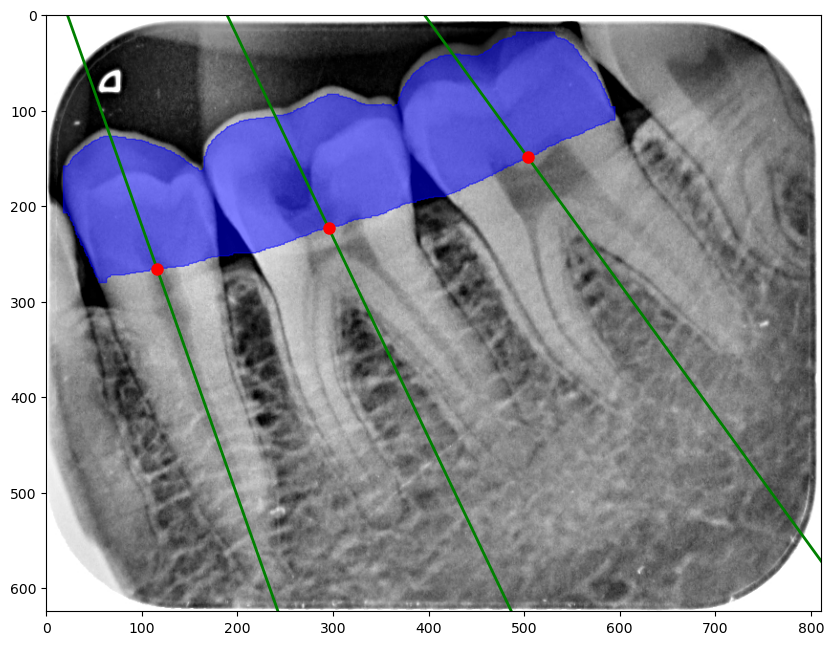

In [20]:
cejs = find_lower_intersections_for_shape(axes=major_axes, polygon= cej_polygon[-1])
plot_results(image, cej_polygon, major_axes, cejs)

In [21]:
def find_higher_intersections_for_shape(polygon, axes):
    """
    Finds the lower (higher y-coordinate) intersection points of multiple axes with a single polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The shape (polygon).
        axes (list of shapely.geometry.LineString): List of major axes (lines).

    Returns:
        List of the lowest intersection points (shapely.geometry.Point or None if no intersection).
    """
    lower_intersections = []

    # Get the polygon's border as a LineString
    polygon_border = LineString(polygon.exterior.coords)

    for axis in axes:
        # Compute intersection of the line with the polygon border
        intersection = axis.intersection(polygon_border)

        # Check if we have multiple intersection points
        if isinstance(intersection, MultiPoint):
            # Get the lower intersection (largest y-coordinate)
            lowest_point = min(intersection.geoms, key=lambda p: p.y)
            lower_intersections.append(lowest_point)

        elif isinstance(intersection, Point):
            lower_intersections.append(intersection)  # Single intersection

        else:
            lower_intersections.append(None)  # No intersection found

    return lower_intersections


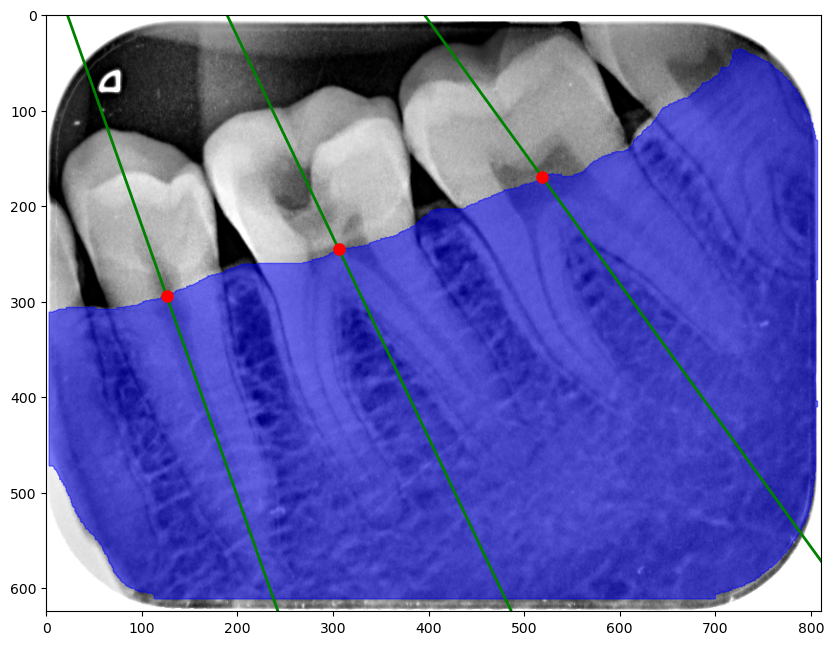

In [22]:
bone_levels = find_higher_intersections_for_shape(axes=major_axes, polygon=bone_polygon[-1])

plot_results(image, bone_polygon, major_axes, bone_levels)

In [23]:
from shapely.geometry import Point
import numpy as np

def calculate_pairwise_distances(list1, list2):
    """
    Calculates the Euclidean distance between corresponding points in two lists.

    Parameters:
        list1 (list of shapely.geometry.Point): First list of points.
        list2 (list of shapely.geometry.Point): Second list of points.

    Returns:
        List of distances (float values).
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")

    distances = [
        np.sqrt((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2)
        for p1, p2 in zip(list1, list2)
    ]

    return distances

In [24]:
distances1 = calculate_pairwise_distances(roots, bone_levels)

distances2 = calculate_pairwise_distances(bone_levels, cejs)
a = np.array(distances2) / np.array(distances1)

In [126]:
np.array([1, 1 , 1 ,1]) / np.array([1, 2 , 3, 4])

array([          1,         0.5,     0.33333,        0.25])

In [127]:
np.array(distances2) / np.array(distances1)

array([    0.56758,       0.552,     0.73869,     0.41451])

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from PIL import Image

import numpy as np

def calculate_pairwise_distances(list1, list2):
    """
    Calculates the Euclidean distance between corresponding points in two lists.

    Parameters:
        list1 (list of shapely.geometry.Point or None): First list of points.
        list2 (list of shapely.geometry.Point or None): Second list of points.

    Returns:
        List of distances (float values) or None for any pair where one or both points are None.
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")

    distances = [
        None if (p1 is None or p2 is None) 
        else np.sqrt((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2)
        for p1, p2 in zip(list1, list2)
    ]

    return distances


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from shapely.geometry import Point
import csv

def plot_points_and_ratios(list1, list2, list3, image, d1, d2, save_path="output.png", csv_path="ratios.csv"):
    """
    Plots the points from three lists on an image, displays the ratio of pairwise distances (d1/d2),
    and saves the ratios in a CSV file.

    Parameters:
        list1, list2, list3 (list of shapely.geometry.Point or None): Lists of points.
        image (PIL.Image or np.ndarray): The background image.
        d1, d2 (list of float or None): Pairwise distances calculated for list1/list2 and list2/list3.
        save_path (str): Path to save the image.
        csv_path (str): Path to save the CSV file.
    """
    # Ensure image is a PIL image
    if isinstance(image, np.ndarray):
        img = Image.fromarray(image)  # Convert NumPy array to PIL image
    else:
        img = image  # Use as-is if already a PIL image

    # Calculate the ratios d1/d2, handling None values
    ratios = [
        None if d1_value is None or d2_value is None else (d1_value / d2_value if d2_value != 0 else 0)
        for d1_value, d2_value in zip(d1, d2)
    ]

    # Plot the image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # Plot the points from list1, list2, list3 (skip None values)
    for i, point in enumerate(list1):
        if point is not None:
            ax.plot(point.x, point.y, 'bo', label=f"Point1-{i+1}")

    for i, point in enumerate(list2):
        if point is not None:
            ax.plot(point.x, point.y, 'go', label=f"Point2-{i+1}")

    for i, point in enumerate(list3):
        if point is not None:
            ax.plot(point.x, point.y, 'ro', label=f"Point3-{i+1}")

    # Annotate distances and ratios between points
    for i, (d1_value, d2_value, ratio) in enumerate(zip(d1, d2, ratios)):
        if list2[i] is not None:
            # Format the ratio display; if ratio is None, show "N/A"
            text = f"Ratio: {ratio:.2f}" if ratio is not None else "Ratio: N/A"
            ax.text(list2[i].x, list2[i].y - 10, text, fontsize=12, color='red', ha='center')

    ax.set_xlim(0, img.width)
    ax.set_ylim(img.height, 0)  # Invert y-axis to align with image coordinates
    ax.axis(False)
    
    # Save the plot as an image
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)
    print(f"Image saved to {save_path}")
    
    # Save ratios to CSV file
    filename = save_path.split('/')[-1].split('.')[0]
    data = {"filename": [filename], "ratios": [ratios]}
    df = pd.DataFrame(data)
    df.to_csv(csv_path, mode='a', header=not pd.io.common.file_exists(csv_path), index=False)
    print(f"Ratios saved to {csv_path}")


def process_and_plot(list1, list2, list3, image, save_path):
    """
    Process the three point lists, calculate distances and ratios, and plot them on an image.
    """
    # Calculate pairwise distances between the lists
    d1 = calculate_pairwise_distances(list1, list2)
    d2 = calculate_pairwise_distances(list2, list3)

    # Plot the points and distances on the image
    plot_points_and_ratios(list1, list2, list3, image, d1, d2, save_path=save_path)


In [26]:
image_path = './data_stage_2/465.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tooth_results = tooth_detection_model.predict(image_path, conf=0.80)                                        
cej_bone_results = cej_bone_detection_model.predict(image_path, conf=0.01, max_det=2, iou=0.7)

p1 = get_obj_polygon(tooth_results, image)
p2 = get_obj_polygon(cej_bone_results, image)

min_area = 150

# Filter polygons
tooth_polygons = filter_small_polygons(p1['tooth'], min_area)
cej_polygon = filter_small_polygons(p2['CEJ'], min_area)
bone_polygon = filter_small_polygons(p2['bone_level'], min_area)


image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/data_stage_2/465.jpg: 448x640 3 tooths, 93.4ms
Speed: 16.7ms preprocess, 93.4ms inference, 3.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/data_stage_2/465.jpg: 448x640 1 bone_level, 1 CEJ, 58.7ms
Speed: 2.2ms preprocess, 58.7ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)


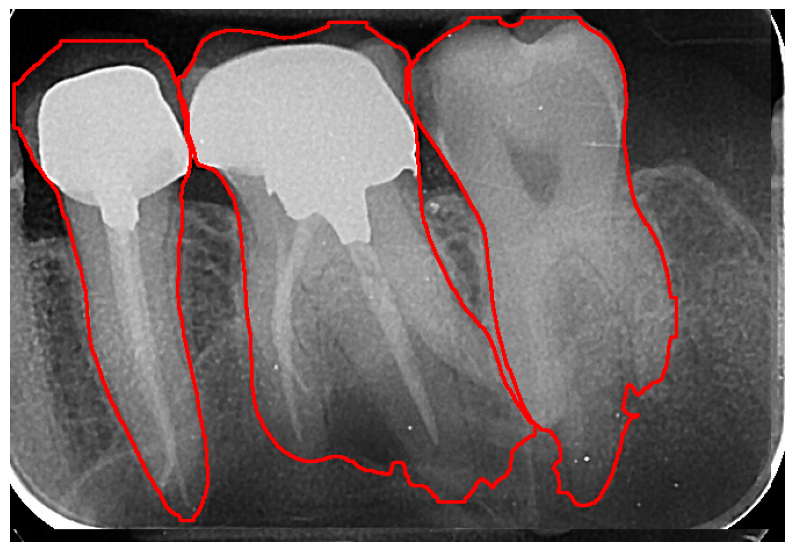

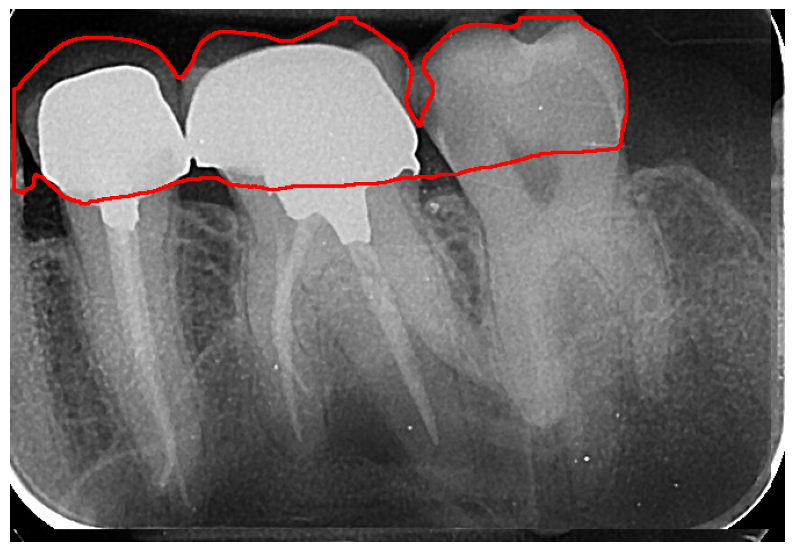

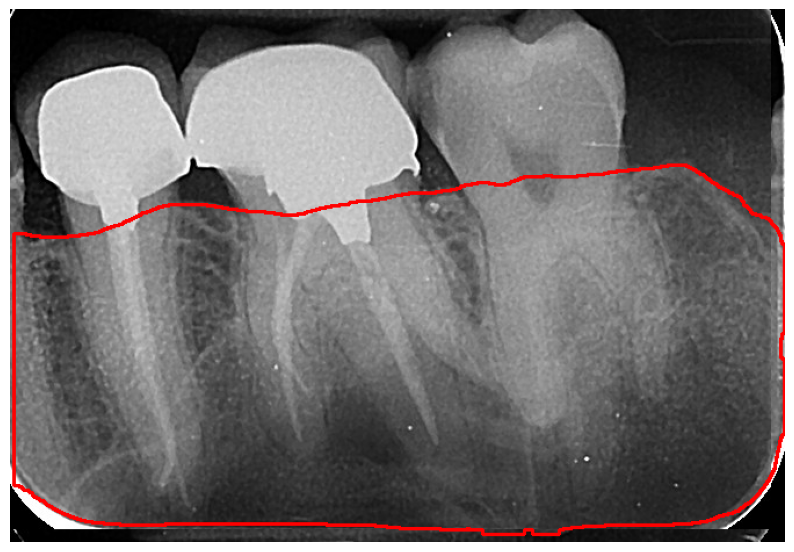

In [27]:
visualize_polygon(tooth_polygons, image)
visualize_polygon(cej_polygon, image)
visualize_polygon(bone_polygon, image)

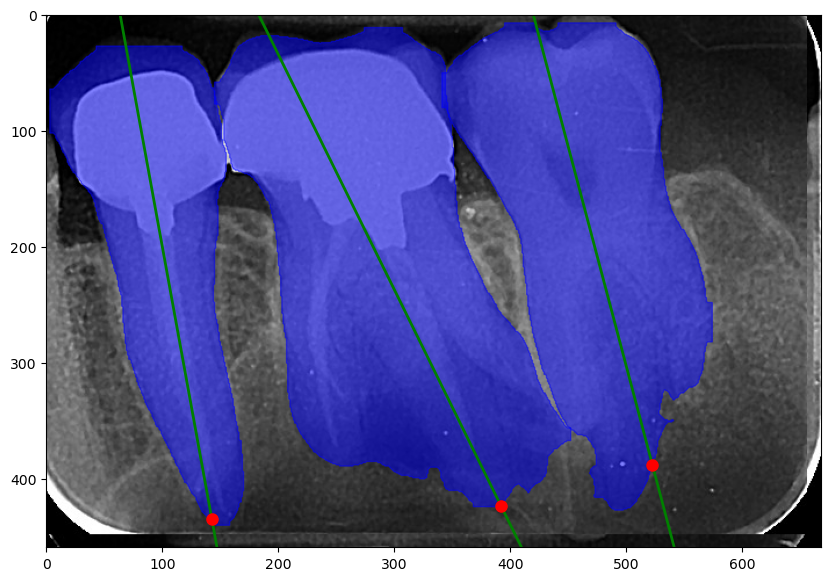

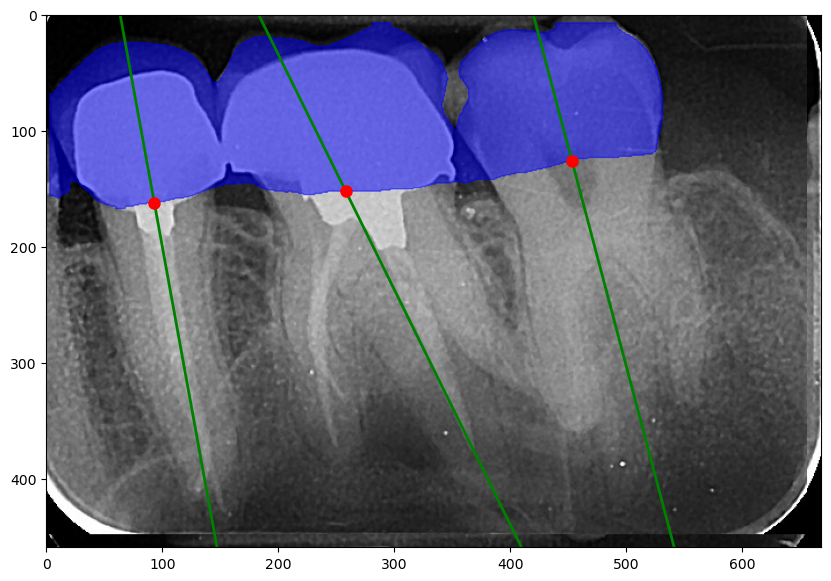

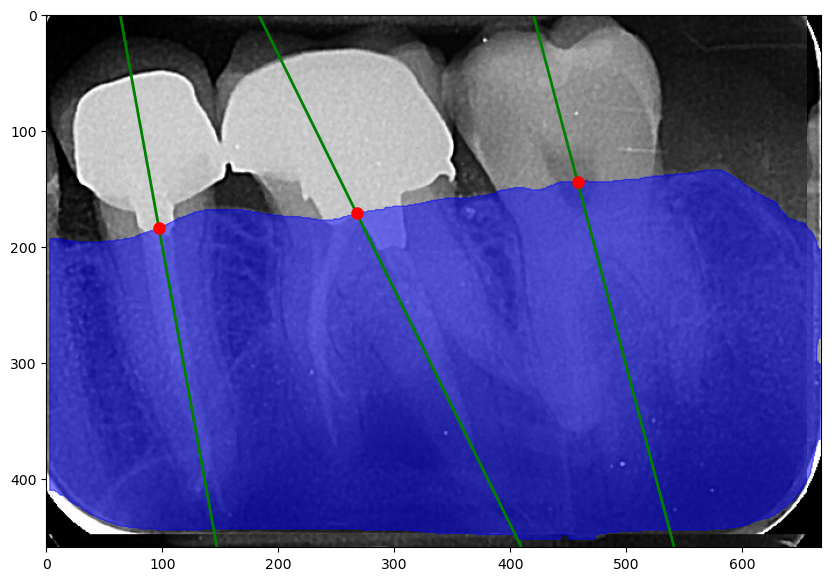

In [28]:
major_axes = get_major_axes(tooth_polygons)

roots = find_lower_intersection(major_axes=major_axes, polygons= tooth_polygons)
plot_results(image, tooth_polygons, major_axes, roots)

cejs = find_lower_intersections_for_shape(axes=major_axes, polygon= cej_polygon[-1])
plot_results(image, cej_polygon, major_axes, cejs)

bone_levels = find_higher_intersections_for_shape(axes=major_axes, polygon=bone_polygon[-1])
plot_results(image, bone_polygon, major_axes, bone_levels)

In [132]:
distances1 = calculate_pairwise_distances(roots, bone_levels)

distances2 = calculate_pairwise_distances(bone_levels, cejs)
# np.array(distances2) / np.array(distances1)

In [133]:
cejs

[<POINT (258.029 152)>, <POINT (93.069 162)>, <POINT (453.077 126)>]

In [134]:
process_and_plot(cejs, bone_levels, roots, image)

TypeError: process_and_plot() missing 1 required positional argument: 'save_path'

In [37]:
import os
import cv2
from tqdm import tqdm

def evalute(image_dir, output_dir):
    """
    Process all images in a directory and save the results.
    
    Parameters:
        image_dir (str): Path to the directory containing images.
        output_dir (str): Path to the directory where output images will be saved.
    """
    os.makedirs(output_dir, exist_ok=True)
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(image_files)} images to process.")
    
    for image_path in tqdm(image_files, desc="Processing Images", unit="image"):
        full_image_path = os.path.join(image_dir, image_path)
        filename = image_path.split('/')[-1]
        
        print(f"Processing {filename}...")
        
        image = cv2.imread(full_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        tooth_results = tooth_detection_model.predict(full_image_path, conf=0.80)                                        
        cej_bone_results = cej_bone_detection_model.predict(full_image_path, conf=0.01, max_det=2, iou=0.7)
        
        p1 = get_obj_polygon(tooth_results, image)
        p2 = get_obj_polygon(cej_bone_results, image)
        
        min_area = 150
        
        # Filter polygons
        tooth_polygons = filter_small_polygons(p1['tooth'], min_area)
        cej_polygon = filter_small_polygons(p2['CEJ'], min_area)
        bone_polygon = filter_small_polygons(p2['bone_level'], min_area)
        
        major_axes = get_major_axes(tooth_polygons)
        
        roots = find_lower_intersection(major_axes=major_axes, polygons=tooth_polygons)
        
        cejs = find_lower_intersections_for_shape(axes=major_axes, polygon=cej_polygon[-1])
        
        bone_levels = find_higher_intersections_for_shape(axes=major_axes, polygon=bone_polygon[-1])
        
        save_path = os.path.join(output_dir, filename)
        process_and_plot(cejs, bone_levels, roots, image, save_path=save_path)
        
        print(f"Saved output to {save_path}")
    
    print("Processing complete.")

In [38]:
evalute('./dataset/cej_bone/images/test', './outputs')

Found 54 images to process.


Processing Images:   0%|          | 0/54 [00:00<?, ?image/s]

Processing 223.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/223.jpg: 512x640 2 tooths, 59.5ms
Speed: 16.4ms preprocess, 59.5ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/223.jpg: 512x640 1 bone_level, 1 CEJ, 59.1ms
Speed: 3.2ms preprocess, 59.1ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   2%|▏         | 1/54 [00:00<00:47,  1.12image/s]

Image saved to ./outputs/223.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/223.jpg
Processing 004.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/004.jpg: 512x640 1 tooth, 51.7ms
Speed: 3.8ms preprocess, 51.7ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/004.jpg: 512x640 1 bone_level, 1 CEJ, 50.7ms
Speed: 3.9ms preprocess, 50.7ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▎         | 2/54 [00:01<00:42,  1.21image/s]

Image saved to ./outputs/004.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/004.jpg
Processing 009.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/009.jpg: 512x640 3 tooths, 51.9ms
Speed: 2.4ms preprocess, 51.9ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/009.jpg: 512x640 1 bone_level, 1 CEJ, 51.8ms
Speed: 2.5ms preprocess, 51.8ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 3/54 [00:02<00:42,  1.20image/s]

Image saved to ./outputs/009.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/009.jpg
Processing 021.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/021.jpg: 512x640 3 tooths, 50.6ms
Speed: 2.3ms preprocess, 50.6ms inference, 3.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/021.jpg: 512x640 1 bone_level, 1 CEJ, 52.5ms
Speed: 2.7ms preprocess, 52.5ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 4/54 [00:03<00:41,  1.22image/s]

Image saved to ./outputs/021.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/021.jpg
Processing 039.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/039.jpg: 512x640 2 tooths, 50.6ms
Speed: 2.2ms preprocess, 50.6ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/039.jpg: 512x640 1 bone_level, 1 CEJ, 52.8ms
Speed: 3.0ms preprocess, 52.8ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▉         | 5/54 [00:04<00:41,  1.18image/s]

Image saved to ./outputs/039.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/039.jpg
Processing 042.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/042.jpg: 512x640 1 tooth, 51.2ms
Speed: 2.2ms preprocess, 51.2ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/042.jpg: 512x640 1 bone_level, 1 CEJ, 52.6ms
Speed: 2.9ms preprocess, 52.6ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  11%|█         | 6/54 [00:04<00:35,  1.36image/s]

Image saved to ./outputs/042.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/042.jpg
Processing 054.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/054.jpg: 512x640 2 tooths, 50.9ms
Speed: 2.7ms preprocess, 50.9ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/054.jpg: 512x640 1 bone_level, 1 CEJ, 52.4ms
Speed: 3.6ms preprocess, 52.4ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  13%|█▎        | 7/54 [00:05<00:36,  1.30image/s]

Image saved to ./outputs/054.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/054.jpg
Processing 060.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/060.jpg: 512x640 3 tooths, 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/060.jpg: 512x640 1 bone_level, 1 CEJ, 51.7ms
Speed: 3.8ms preprocess, 51.7ms inference, 4.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  15%|█▍        | 8/54 [00:06<00:36,  1.27image/s]

Image saved to ./outputs/060.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/060.jpg
Processing 075.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/075.jpg: 512x640 2 tooths, 52.0ms
Speed: 2.9ms preprocess, 52.0ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/075.jpg: 512x640 1 bone_level, 1 CEJ, 53.1ms
Speed: 3.2ms preprocess, 53.1ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 9/54 [00:07<00:35,  1.26image/s]

Image saved to ./outputs/075.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/075.jpg
Processing 079.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/079.jpg: 512x640 3 tooths, 51.1ms
Speed: 3.2ms preprocess, 51.1ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/079.jpg: 512x640 1 bone_level, 1 CEJ, 52.2ms
Speed: 2.6ms preprocess, 52.2ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▊        | 10/54 [00:08<00:36,  1.22image/s]

Image saved to ./outputs/079.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/079.jpg
Processing 090.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/090.jpg: 512x640 1 tooth, 59.5ms
Speed: 3.4ms preprocess, 59.5ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/090.jpg: 512x640 1 bone_level, 1 CEJ, 59.6ms
Speed: 2.6ms preprocess, 59.6ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  20%|██        | 11/54 [00:08<00:35,  1.22image/s]

Image saved to ./outputs/090.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/090.jpg
Processing 092.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/092.jpg: 512x640 2 tooths, 53.0ms
Speed: 3.4ms preprocess, 53.0ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/092.jpg: 512x640 1 bone_level, 1 CEJ, 52.2ms
Speed: 3.2ms preprocess, 52.2ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  22%|██▏       | 12/54 [00:09<00:33,  1.24image/s]

Image saved to ./outputs/092.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/092.jpg
Processing 110.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/110.jpg: 512x640 2 tooths, 51.1ms
Speed: 2.2ms preprocess, 51.1ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/110.jpg: 512x640 1 bone_level, 1 CEJ, 52.6ms
Speed: 2.1ms preprocess, 52.6ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▍       | 13/54 [00:10<00:32,  1.24image/s]

Image saved to ./outputs/110.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/110.jpg
Processing 128.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/128.jpg: 544x640 3 tooths, 58.9ms
Speed: 2.8ms preprocess, 58.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/128.jpg: 544x640 1 bone_level, 1 CEJ, 60.2ms
Speed: 2.2ms preprocess, 60.2ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  26%|██▌       | 14/54 [00:11<00:32,  1.21image/s]

Image saved to ./outputs/128.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/128.jpg
Processing 169.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/169.jpg: 512x640 2 tooths, 51.2ms
Speed: 3.9ms preprocess, 51.2ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/169.jpg: 512x640 1 bone_level, 1 CEJ, 53.6ms
Speed: 2.5ms preprocess, 53.6ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  28%|██▊       | 15/54 [00:12<00:32,  1.22image/s]

Image saved to ./outputs/169.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/169.jpg
Processing 181.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/181.jpg: 512x640 1 tooth, 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/181.jpg: 512x640 1 bone_level, 1 CEJ, 52.6ms
Speed: 2.6ms preprocess, 52.6ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|██▉       | 16/54 [00:12<00:31,  1.21image/s]

Image saved to ./outputs/181.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/181.jpg
Processing 190.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/190.jpg: 512x640 3 tooths, 51.0ms
Speed: 2.7ms preprocess, 51.0ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/190.jpg: 512x640 1 bone_level, 1 CEJ, 51.8ms
Speed: 2.6ms preprocess, 51.8ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███▏      | 17/54 [00:13<00:30,  1.23image/s]

Image saved to ./outputs/190.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/190.jpg
Processing 192.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/192.jpg: 512x640 2 tooths, 52.1ms
Speed: 3.6ms preprocess, 52.1ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/192.jpg: 512x640 1 bone_level, 1 CEJ, 51.5ms
Speed: 2.9ms preprocess, 51.5ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 18/54 [00:14<00:29,  1.22image/s]

Image saved to ./outputs/192.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/192.jpg
Processing 193.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/193.jpg: 512x640 3 tooths, 51.6ms
Speed: 3.2ms preprocess, 51.6ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/193.jpg: 512x640 1 bone_level, 1 CEJ, 51.0ms
Speed: 2.7ms preprocess, 51.0ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  35%|███▌      | 19/54 [00:15<00:28,  1.24image/s]

Image saved to ./outputs/193.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/193.jpg
Processing 195.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/195.jpg: 512x640 3 tooths, 50.6ms
Speed: 3.5ms preprocess, 50.6ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/195.jpg: 512x640 1 bone_level, 1 CEJ, 52.5ms
Speed: 3.4ms preprocess, 52.5ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 20/54 [00:16<00:27,  1.23image/s]

Image saved to ./outputs/195.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/195.jpg
Processing 214.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/214.jpg: 512x640 1 tooth, 51.3ms
Speed: 2.7ms preprocess, 51.3ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/214.jpg: 512x640 1 bone_level, 1 CEJ, 51.3ms
Speed: 3.0ms preprocess, 51.3ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 21/54 [00:17<00:26,  1.24image/s]

Image saved to ./outputs/214.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/214.jpg
Processing 217.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/217.jpg: 640x512 1 tooth, 52.2ms
Speed: 3.3ms preprocess, 52.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/217.jpg: 640x512 1 bone_level, 1 CEJ, 53.8ms
Speed: 2.6ms preprocess, 53.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  41%|████      | 22/54 [00:17<00:26,  1.22image/s]

Image saved to ./outputs/217.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/217.jpg
Processing 218.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/218.jpg: 512x640 2 tooths, 52.3ms
Speed: 3.9ms preprocess, 52.3ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/218.jpg: 512x640 1 bone_level, 1 CEJ, 53.4ms
Speed: 2.8ms preprocess, 53.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 23/54 [00:18<00:26,  1.17image/s]

Image saved to ./outputs/218.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/218.jpg
Processing 219.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/219.jpg: 512x640 3 tooths, 51.3ms
Speed: 2.7ms preprocess, 51.3ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/219.jpg: 512x640 1 bone_level, 1 CEJ, 52.1ms
Speed: 2.9ms preprocess, 52.1ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  44%|████▍     | 24/54 [00:19<00:24,  1.20image/s]

Image saved to ./outputs/219.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/219.jpg
Processing 228.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/228.jpg: 512x640 2 tooths, 51.3ms
Speed: 3.5ms preprocess, 51.3ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/228.jpg: 512x640 1 bone_level, 1 CEJ, 51.6ms
Speed: 3.0ms preprocess, 51.6ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▋     | 25/54 [00:20<00:23,  1.23image/s]

Image saved to ./outputs/228.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/228.jpg
Processing 231.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/231.jpg: 512x640 3 tooths, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/231.jpg: 512x640 1 bone_level, 1 CEJ, 51.0ms
Speed: 3.4ms preprocess, 51.0ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 26/54 [00:21<00:24,  1.17image/s]

Image saved to ./outputs/231.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/231.jpg
Processing 232.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/232.jpg: 512x640 2 tooths, 50.2ms
Speed: 3.9ms preprocess, 50.2ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/232.jpg: 512x640 1 bone_level, 1 CEJ, 51.8ms
Speed: 4.1ms preprocess, 51.8ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|█████     | 27/54 [00:22<00:24,  1.10image/s]

Image saved to ./outputs/232.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/232.jpg
Processing 261.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/261.jpg: 480x640 1 tooth, 53.6ms
Speed: 3.4ms preprocess, 53.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/261.jpg: 480x640 1 bone_level, 1 CEJ, 52.0ms
Speed: 2.4ms preprocess, 52.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 28/54 [00:23<00:22,  1.16image/s]

Image saved to ./outputs/261.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/261.jpg
Processing 273.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/273.jpg: 512x640 3 tooths, 52.1ms
Speed: 2.3ms preprocess, 52.1ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/273.jpg: 512x640 1 bone_level, 1 CEJ, 53.6ms
Speed: 3.5ms preprocess, 53.6ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▎    | 29/54 [00:23<00:21,  1.17image/s]

Image saved to ./outputs/273.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/273.jpg
Processing 284.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/284.jpg: 512x640 3 tooths, 51.3ms
Speed: 2.4ms preprocess, 51.3ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/284.jpg: 512x640 1 bone_level, 1 CEJ, 52.3ms
Speed: 3.0ms preprocess, 52.3ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▌    | 30/54 [00:24<00:20,  1.19image/s]

Image saved to ./outputs/284.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/284.jpg
Processing 291.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/291.jpg: 512x640 1 tooth, 58.2ms
Speed: 4.2ms preprocess, 58.2ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/291.jpg: 512x640 1 bone_level, 1 CEJ, 59.6ms
Speed: 2.1ms preprocess, 59.6ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 31/54 [00:25<00:19,  1.18image/s]

Image saved to ./outputs/291.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/291.jpg
Processing 297.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/297.jpg: 512x640 3 tooths, 51.8ms
Speed: 3.2ms preprocess, 51.8ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/297.jpg: 512x640 1 bone_level, 1 CEJ, 52.9ms
Speed: 3.5ms preprocess, 52.9ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  59%|█████▉    | 32/54 [00:26<00:18,  1.21image/s]

Image saved to ./outputs/297.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/297.jpg
Processing 305.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/305.jpg: 512x640 2 tooths, 51.1ms
Speed: 3.3ms preprocess, 51.1ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/305.jpg: 512x640 1 bone_level, 1 CEJ, 52.2ms
Speed: 3.1ms preprocess, 52.2ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  61%|██████    | 33/54 [00:27<00:16,  1.24image/s]

Image saved to ./outputs/305.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/305.jpg
Processing 309.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/309.jpg: 512x640 2 tooths, 51.3ms
Speed: 3.6ms preprocess, 51.3ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/309.jpg: 512x640 1 bone_level, 1 CEJ, 52.5ms
Speed: 2.5ms preprocess, 52.5ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  63%|██████▎   | 34/54 [00:27<00:16,  1.25image/s]

Image saved to ./outputs/309.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/309.jpg
Processing 314.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/314.jpg: 512x640 1 tooth, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/314.jpg: 512x640 1 bone_level, 1 CEJ, 52.3ms
Speed: 2.4ms preprocess, 52.3ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▍   | 35/54 [00:28<00:15,  1.26image/s]

Image saved to ./outputs/314.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/314.jpg
Processing 316.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/316.jpg: 544x640 2 tooths, 60.1ms
Speed: 2.4ms preprocess, 60.1ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/316.jpg: 544x640 1 bone_level, 1 CEJ, 59.5ms
Speed: 2.8ms preprocess, 59.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  67%|██████▋   | 36/54 [00:29<00:14,  1.22image/s]

Image saved to ./outputs/316.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/316.jpg
Processing 322.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/322.jpg: 544x640 3 tooths, 67.6ms
Speed: 2.9ms preprocess, 67.6ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/322.jpg: 544x640 1 bone_level, 1 CEJ, 66.7ms
Speed: 2.8ms preprocess, 66.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▊   | 37/54 [00:30<00:14,  1.19image/s]

Image saved to ./outputs/322.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/322.jpg
Processing 324.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/324.jpg: 512x640 3 tooths, 54.5ms
Speed: 3.7ms preprocess, 54.5ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/324.jpg: 512x640 1 bone_level, 1 CEJ, 53.0ms
Speed: 2.5ms preprocess, 53.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  70%|███████   | 38/54 [00:31<00:13,  1.17image/s]

Image saved to ./outputs/324.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/324.jpg
Processing 337.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/337.jpg: 512x640 3 tooths, 52.8ms
Speed: 3.7ms preprocess, 52.8ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/337.jpg: 512x640 1 bone_level, 1 CEJ, 52.6ms
Speed: 2.7ms preprocess, 52.6ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  72%|███████▏  | 39/54 [00:32<00:12,  1.17image/s]

Image saved to ./outputs/337.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/337.jpg
Processing 350.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/350.jpg: 512x640 2 tooths, 52.7ms
Speed: 3.4ms preprocess, 52.7ms inference, 3.7ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/350.jpg: 512x640 1 bone_level, 1 CEJ, 51.8ms
Speed: 3.5ms preprocess, 51.8ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  74%|███████▍  | 40/54 [00:33<00:12,  1.15image/s]

Image saved to ./outputs/350.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/350.jpg
Processing 351.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/351.jpg: 512x640 3 tooths, 63.0ms
Speed: 4.3ms preprocess, 63.0ms inference, 4.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/351.jpg: 512x640 1 bone_level, 1 CEJ, 51.7ms
Speed: 2.8ms preprocess, 51.7ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 41/54 [00:34<00:12,  1.02image/s]

Image saved to ./outputs/351.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/351.jpg
Processing 354.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/354.jpg: 512x640 4 tooths, 59.4ms
Speed: 3.0ms preprocess, 59.4ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/354.jpg: 512x640 1 bone_level, 1 CEJ, 58.9ms
Speed: 3.7ms preprocess, 58.9ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 42/54 [00:35<00:11,  1.02image/s]

Image saved to ./outputs/354.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/354.jpg
Processing 357.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/357.jpg: 512x640 2 tooths, 52.9ms
Speed: 3.0ms preprocess, 52.9ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/357.jpg: 512x640 1 bone_level, 1 CEJ, 52.6ms
Speed: 2.5ms preprocess, 52.6ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|███████▉  | 43/54 [00:36<00:10,  1.09image/s]

Image saved to ./outputs/357.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/357.jpg
Processing 369.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/369.jpg: 512x640 3 tooths, 55.8ms
Speed: 4.5ms preprocess, 55.8ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/369.jpg: 512x640 1 bone_level, 1 CEJ, 52.0ms
Speed: 3.7ms preprocess, 52.0ms inference, 4.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████▏ | 44/54 [00:36<00:09,  1.11image/s]

Image saved to ./outputs/369.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/369.jpg
Processing 375.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/375.jpg: 512x640 2 tooths, 51.0ms
Speed: 3.9ms preprocess, 51.0ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/375.jpg: 512x640 1 bone_level, 1 CEJ, 53.0ms
Speed: 2.7ms preprocess, 53.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  83%|████████▎ | 45/54 [00:37<00:07,  1.14image/s]

Image saved to ./outputs/375.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/375.jpg
Processing 407.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/407.jpg: 512x640 2 tooths, 52.1ms
Speed: 2.7ms preprocess, 52.1ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/407.jpg: 512x640 1 bone_level, 1 CEJ, 52.4ms
Speed: 2.9ms preprocess, 52.4ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  85%|████████▌ | 46/54 [00:38<00:06,  1.15image/s]

Image saved to ./outputs/407.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/407.jpg
Processing 414.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/414.jpg: 512x640 1 tooth, 53.1ms
Speed: 3.5ms preprocess, 53.1ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/414.jpg: 512x640 1 bone_level, 1 CEJ, 52.3ms
Speed: 2.7ms preprocess, 52.3ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  87%|████████▋ | 47/54 [00:39<00:06,  1.16image/s]

Image saved to ./outputs/414.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/414.jpg
Processing 416.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/416.jpg: 512x640 2 tooths, 53.4ms
Speed: 2.7ms preprocess, 53.4ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/416.jpg: 512x640 1 bone_level, 1 CEJ, 51.9ms
Speed: 2.6ms preprocess, 51.9ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 48/54 [00:40<00:05,  1.19image/s]

Image saved to ./outputs/416.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/416.jpg
Processing 424.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/424.jpg: 512x640 3 tooths, 51.9ms
Speed: 3.0ms preprocess, 51.9ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/424.jpg: 512x640 1 bone_level, 1 CEJ, 53.0ms
Speed: 2.5ms preprocess, 53.0ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  91%|█████████ | 49/54 [00:41<00:04,  1.21image/s]

Image saved to ./outputs/424.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/424.jpg
Processing 425.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/425.jpg: 512x640 2 tooths, 52.4ms
Speed: 3.1ms preprocess, 52.4ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/425.jpg: 512x640 1 bone_level, 1 CEJ, 52.0ms
Speed: 2.5ms preprocess, 52.0ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  93%|█████████▎| 50/54 [00:41<00:03,  1.24image/s]

Image saved to ./outputs/425.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/425.jpg
Processing 453.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/453.jpg: 512x640 3 tooths, 51.8ms
Speed: 2.7ms preprocess, 51.8ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/453.jpg: 512x640 1 bone_level, 1 CEJ, 52.8ms
Speed: 2.9ms preprocess, 52.8ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  94%|█████████▍| 51/54 [00:42<00:02,  1.38image/s]

Image saved to ./outputs/453.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/453.jpg
Processing 465.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/465.jpg: 448x640 3 tooths, 49.3ms
Speed: 2.4ms preprocess, 49.3ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/465.jpg: 448x640 1 bone_level, 1 CEJ, 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▋| 52/54 [00:43<00:01,  1.39image/s]

Image saved to ./outputs/465.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/465.jpg
Processing 471.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/471.jpg: 448x640 3 tooths, 48.9ms
Speed: 2.1ms preprocess, 48.9ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/471.jpg: 448x640 1 bone_level, 1 CEJ, 49.1ms
Speed: 2.6ms preprocess, 49.1ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  98%|█████████▊| 53/54 [00:43<00:00,  1.40image/s]

Image saved to ./outputs/471.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/471.jpg
Processing 475.jpg...

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/475.jpg: 512x640 3 tooths, 53.7ms
Speed: 3.2ms preprocess, 53.7ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /media/moein/Programming and Uni/Master - Amirkabir/Perio-detection/perio-detection/dataset/cej_bone/images/test/475.jpg: 512x640 1 bone_level, 1 CEJ, 54.3ms
Speed: 2.7ms preprocess, 54.3ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images: 100%|██████████| 54/54 [00:44<00:00,  1.21image/s]

Image saved to ./outputs/475.jpg
Ratios saved to ratios.csv
Saved output to ./outputs/475.jpg
Processing complete.
